In [2]:
import glob
import lxml.etree as ET
from pandas import Series, DataFrame
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

import os
os.chdir("/home/thibault/dev/these/")

NS = {"t": "http://www.tei-c.org/ns/1.0"}

xml = ET.parse("these-corpus/collated.xml")

print(len(xml.xpath("//t:div", namespaces=NS)))
print(len(xml.xpath("//t:w[@pos!='PUNC']", namespaces=NS)))

2516
38201


# Tags les plus communs

[('acte', 1288), ('metonymie', 789), ('male', 573), ('metaphore', 459), ('female', 419), ('mentula', 399), ('euphemism', 379), ('cunnus', 305), ('composite', 299), ('womb', 213), ('culus', 162), ('fututio', 113), ('violence', 104), ('coeo', 94), ('adjoiningParts', 93), ('amo', 91), ('aidoion', 80), ('dormirAvec', 71), ('specialisation', 70), ('animal', 59)]
199


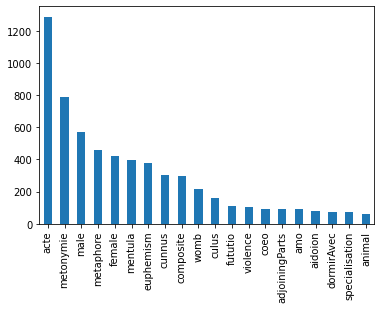

In [3]:
anas = Counter([tag[1:] for ana in xml.xpath("//t:div/@ana", namespaces=NS) for tag in ana.split()])
print(anas.most_common(20))
Series(dict(anas.most_common(20))).plot.bar()
print(len(anas))

# Co-occurrence de tags

<AxesSubplot:xlabel='Catégorie 2', ylabel='Catégorie 1'>

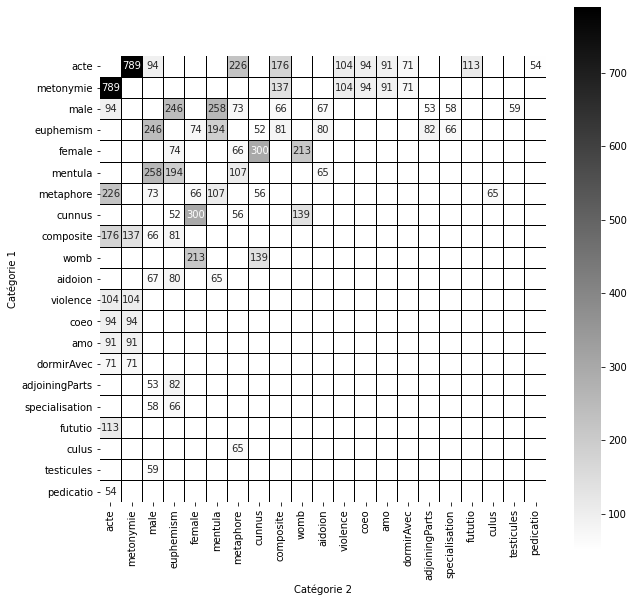

In [3]:
combined = Counter([
    (tag1[1:], tag2[1:])
    for ana in xml.xpath("//t:div/@ana", namespaces=NS)
    for tag1 in ana.split()
    for tag2 in ana.split()
    if tag1 != tag2
])
matrix = {
    a_tag: {
        tag2: amount
        for (tag1, tag2), amount in combined.items()
        if a_tag == tag1
    }
    for a_tag in anas.keys()
}

accounts = [
    {"Catégorie 1": tag1, "Catégorie 2": tag2, "Compte": amount}
    for (tag1, tag2), amount in combined.items()
]
matrix = DataFrame(accounts)

MIN = 50

fig = plt.figure(figsize=(10,10))
ax = fig.gca()
piv = matrix[matrix.Compte > MIN].pivot("Catégorie 1", "Catégorie 2", "Compte")
order = piv.sum(axis=1).sort_values(ascending=False).index
sns.heatmap(
    piv[order].loc[order],
    cmap=sns.color_palette("gray_r", as_cmap=True),
    square=True,
    vmin=MIN,
    annot=True,
    fmt=".0f",
    linecolor="#000000",
    linewidths=.05,
    ax=ax
)

#print(matrix[(matrix["Catégorie 1"] == "violence") & (matrix["Compte"] > 0)])


Text(114.0, 0.5, '')

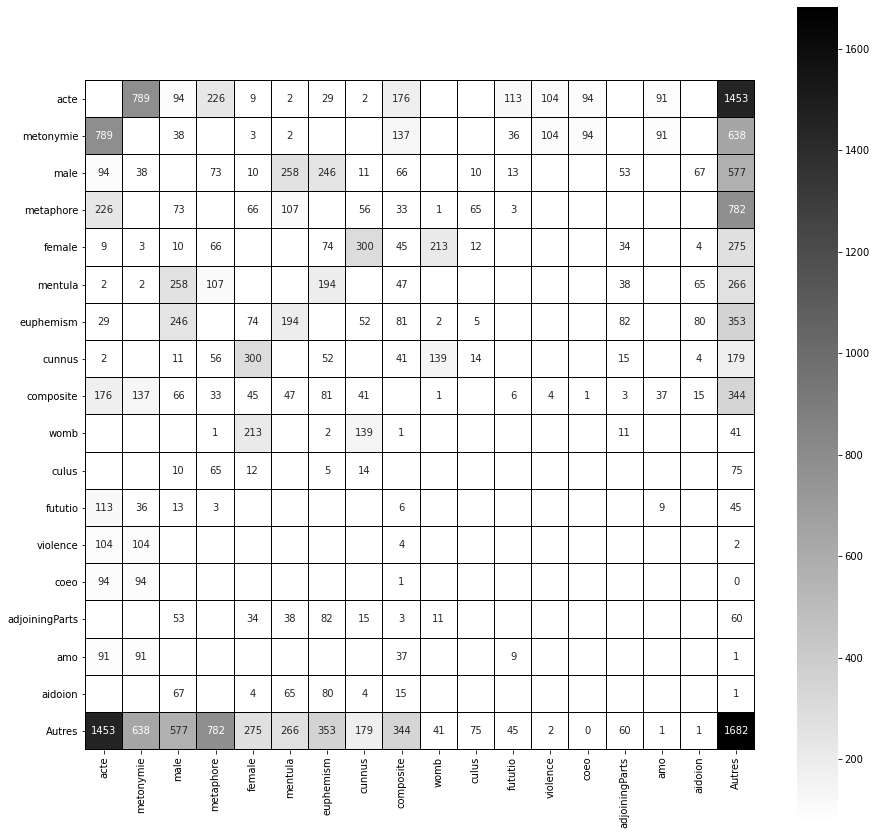

In [4]:
MIN = 75
# Copy the original matrix to not void the previous work
matrix2 = matrix.copy()
# Make the pivot early, without filtering
piv2 = matrix.pivot("Catégorie 1", "Catégorie 2", "Compte")

# Retrieve element whose sum of apparition are higher than 50
kept = [key for key, val in anas.items() if val > MIN]
autre = set(matrix["Catégorie 1"].unique()) - set(kept)
order = sorted(kept, key=lambda x: anas[x], reverse=True)


piv2["Autres"] = piv2.sum(axis=1) - piv2[order].sum(axis=1)
#print(order.tolist())
#dict(zip(piv2.loc[order.tolist()].columns, piv2["Autres"].loc[order.tolist()].tolist()))
autres = piv2["Autres"].loc[autre].sum()
dico = piv2["Autres"].loc[order].to_dict()
dico["Autres"] = autres
piv2.loc["Autres"] = dico

fig = plt.figure(figsize=(15,15))
ax = fig.gca()
sns.heatmap(
    piv2[order+["Autres"]].loc[order+["Autres"]],
    cmap=sns.color_palette("gray_r", as_cmap=True),
    square=True,
    vmin=MIN,
    annot=True,
    fmt=".0f",
    linecolor="#000000",
    linewidths=.05,
    ax=ax
)
ax.set_xlabel("")
ax.set_ylabel("")

# Tags

In [5]:
authors = Counter(xml.xpath("//t:div/t:bibl[@type='source']//t:persName[@xml:lang='fr']/text()", namespaces=NS))

Text(0.5, 0, 'Dispersion du nombre \nde documents par auteurs')

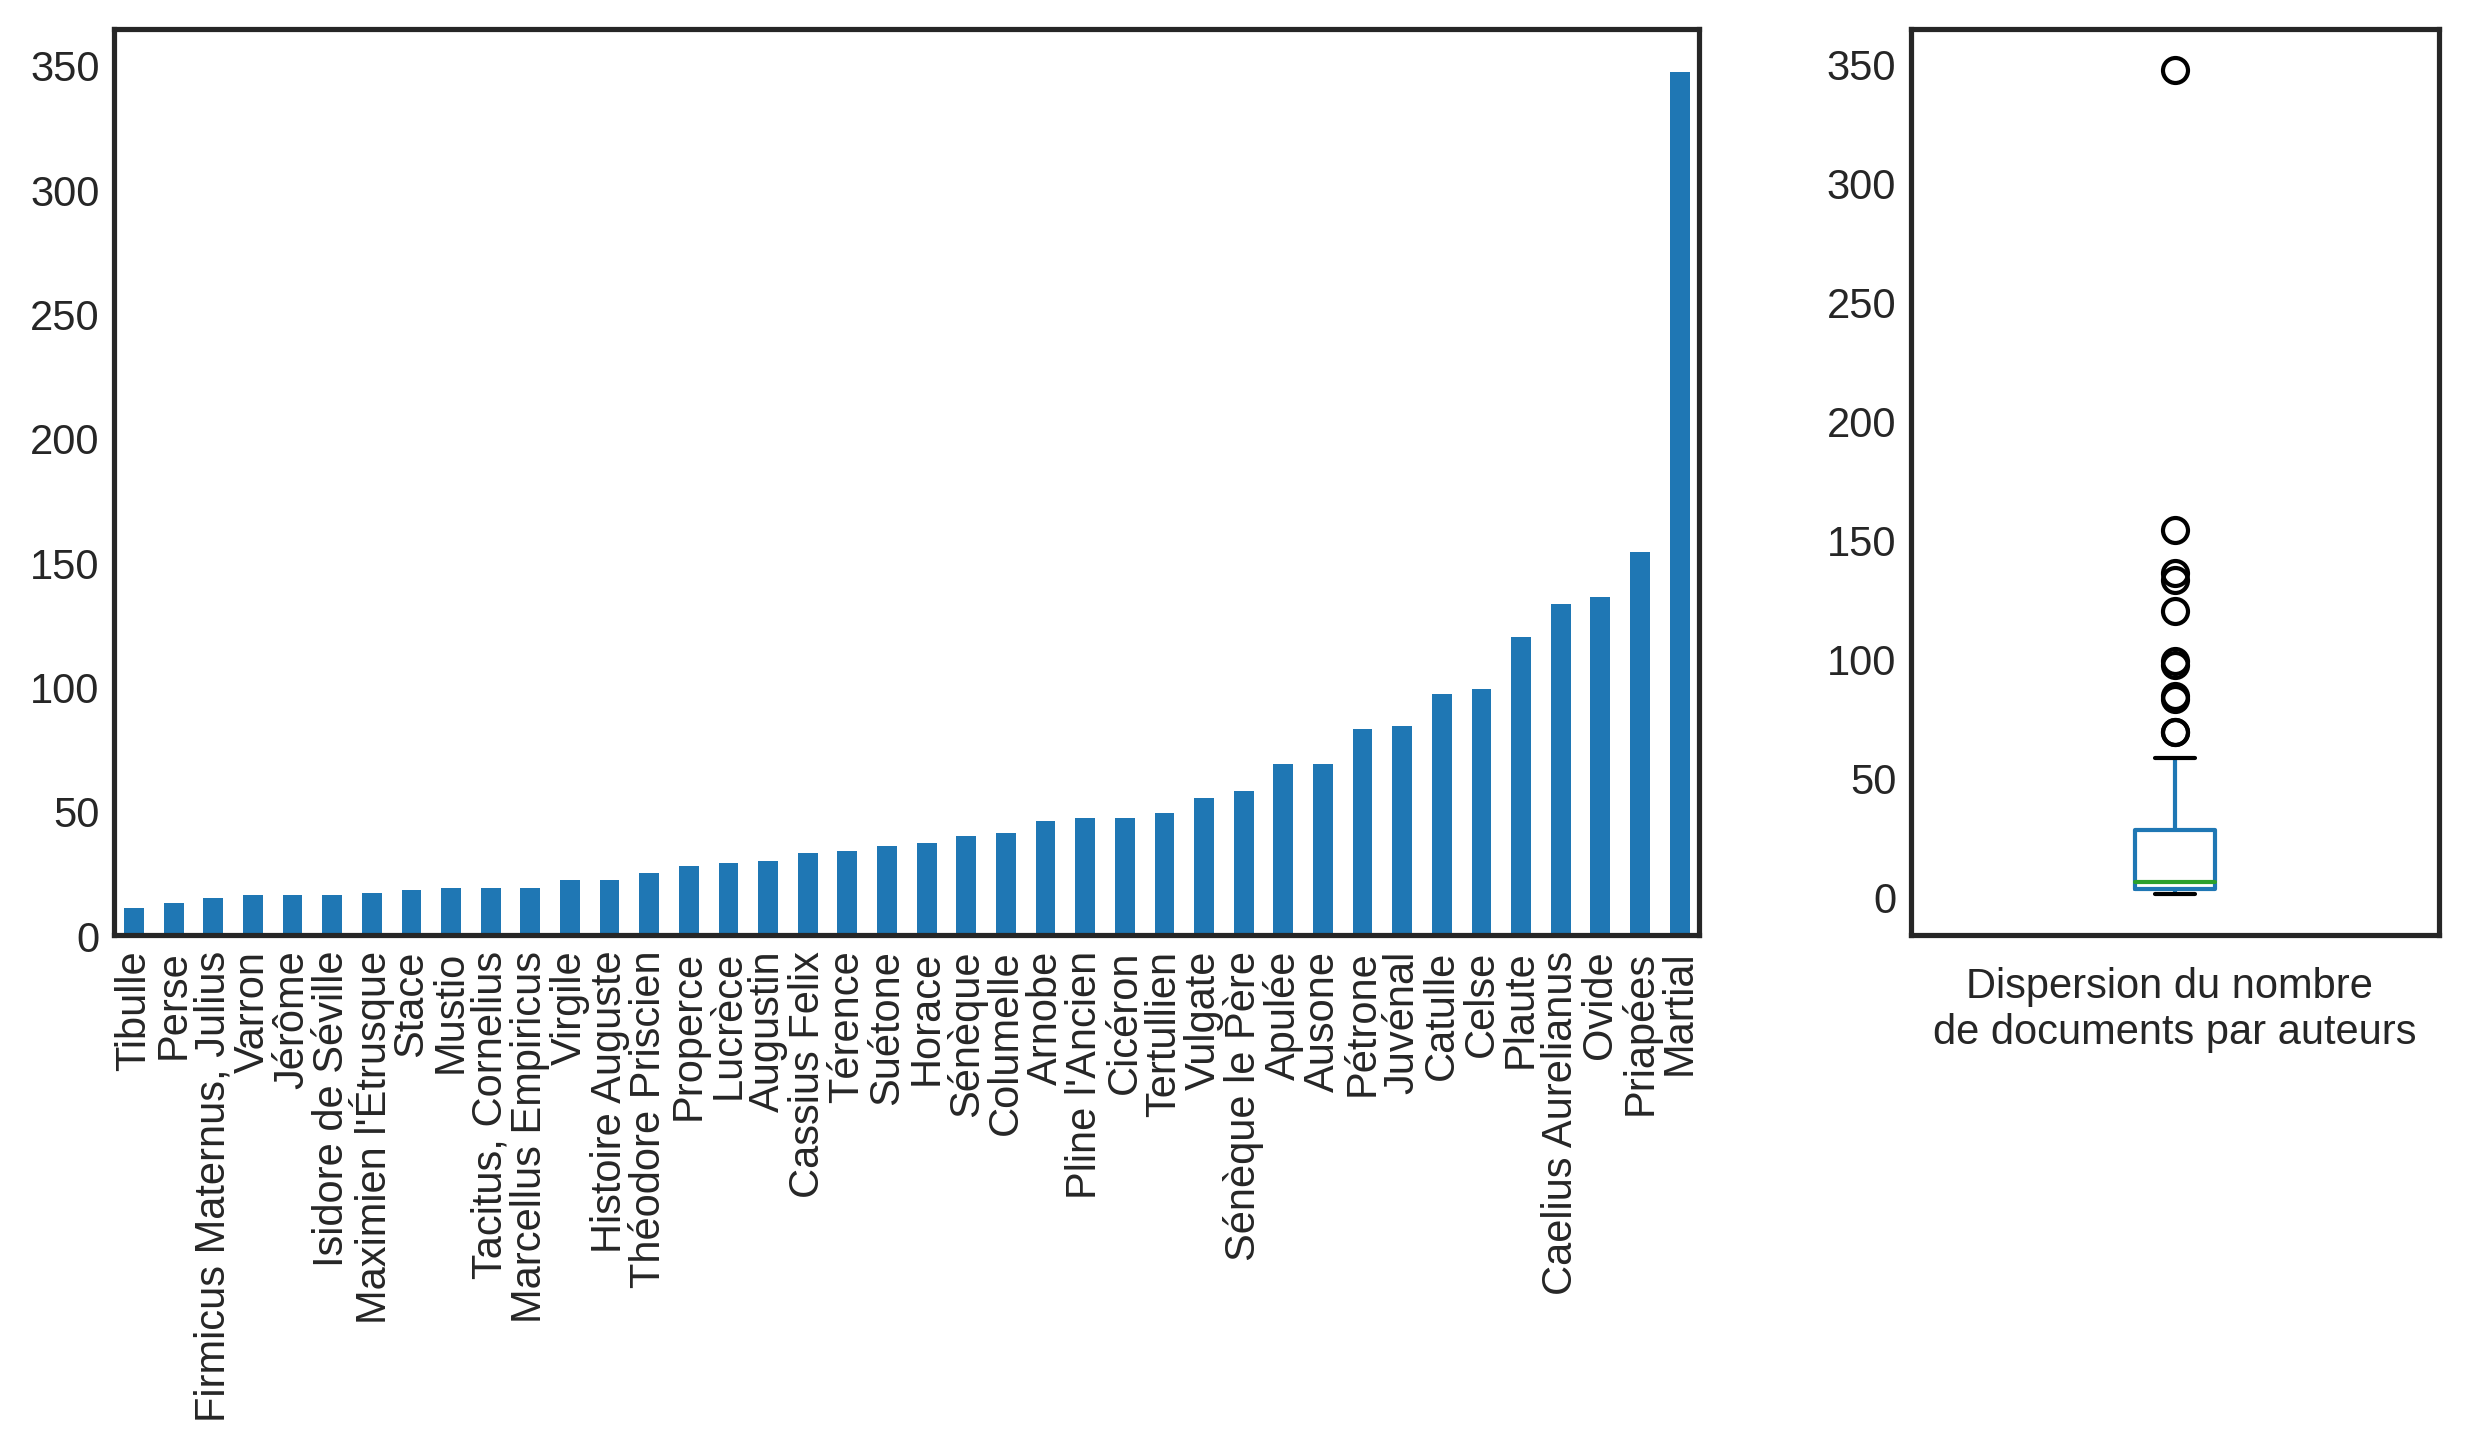

In [6]:
plt.style.use('seaborn-white')
fig, (ax1, ax2) = plt.subplots(1, 2, dpi=300, figsize=(10, 4), gridspec_kw={'width_ratios': [3, 1]})
S = Series(authors)
S[S > 10].sort_values().plot.bar(ax=ax1)
S.plot.box(ax=ax2)
ax2.set_xticklabels([""])
ax2.set_xlabel("Dispersion du nombre \nde documents par auteurs")

# Dates et auteurs

In [7]:
# <idno type="CTS_URN">

# Importance dans le corpus / importance dans Adams

In [22]:
import glob
from collections import defaultdict
from MyCapytain.common.reference import URN

already_read = []
all_authors = defaultdict(lambda: 0)

for file in glob.glob("../latin-lemmatized-texts/lemmatized/xml/*.xml"):
    local_xml = ET.parse(file)
    urn = local_xml.xpath("//t:idno/text()", namespaces=NS)[0]
    if str((URN(urn)).upTo(URN.WORK)) in already_read:
        continue
    already_read.append(str((URN(urn)).upTo(URN.WORK)))
    urn = str((URN(urn)).upTo(URN.TEXTGROUP))
    words = len(local_xml.xpath("//t:w[@pos!='PUNC']", namespaces=NS))
    all_authors[urn] += words

In [108]:
authors = Counter(
    work.split(".")[0]
    for work in xml.xpath(
        "//t:idno[@type='CTS_URN']/text()",
        namespaces=NS
    )
)
name_authors = dict([
    (
        sample.xpath("./t:idno[@type='CTS_URN']/text()", namespaces=NS)[0].split(".")[0],
        (
            sample.xpath(".//t:persName[@xml:lang='fr']/text()", namespaces=NS) + \
            sample.xpath(".//t:title[@xml:lang='lat']/text()", namespaces=NS)
        )[0].split("/")[0].strip()
    )
    for sample in xml.xpath(
        "//t:bibl[@type='source']",
        namespaces=NS
    )
])
example_word_counts = defaultdict(lambda:0)
for sample in xml.xpath("//t:quote", namespaces=NS):
    try:
        example_word_counts[sample.attrib["source"].split(".")[0]] += len(
            sample.xpath(".//t:w[@pos!='PUNC']", namespaces=NS)
        )
    except:
        print(ET.tostring(sample, encoding=str))

<quote xmlns="http://www.tei-c.org/ns/1.0">Die Lösung ist λείχει. </quote>
                


In [109]:
df = DataFrame([
    [name_authors.get(tg, "Inconnu"), tg, words, authors.get(tg, 0), example_word_counts.get(tg, 0)]
    for tg, words in all_authors.items()
], columns=["Auteur", "Textgroup", "MotsComplet", "Exemples", "MotsExemples"])
df["MotsComplet%"] = df["MotsComplet"] / df["MotsComplet"].sum()
df["MotsExemples%"] = df["MotsExemples"] / df["MotsExemples"].sum()
df["Exemples%"] = df["Exemples"] / df["Exemples"].sum()
df["Exemples%/MotsComplet%"] = df["Exemples%"] / df["MotsComplet%"]
df["MotsExemples%/MotsComplet%"] = df["MotsExemples%"] / df["MotsComplet%"]
df[df["Exemples%/MotsComplet%"] != .0].sort_values("Exemples%/MotsComplet%", ascending=False)

,Auteur,Textgroup,MotsComplet,Exemples,MotsExemples,MotsComplet%,MotsExemples%,Exemples%,Exemples%/MotsComplet%,MotsExemples%/MotsComplet%
106,Priapées,urn:cts:latinLit:phi1103,3477,154,1997,0.000216,0.052445,0.061551,285.244399,243.045534
176,Catulle,urn:cts:latinLit:phi0472,13080,97,1227,0.000812,0.032223,0.038769,47.760084,39.696397
158,Martial,urn:cts:latinLit:phi1294,57582,347,4089,0.003574,0.107385,0.138689,38.810016,30.050011
32,Maximien l'Étrusque,urn:cts:latinLit:stoa0196,4310,17,263,0.000267,0.006907,0.006795,25.402283,25.822171
194,Juvénal,urn:cts:latinLit:phi1276,25404,84,1149,0.001577,0.030175,0.033573,21.295031,19.139571
...,...,...,...,...,...,...,...,...,...,...
15,De Lapsu virginis consecratae liber,urn:cts:latinLit:stoa0022,524393,9,178,0.032544,0.004675,0.003597,0.110532,0.143641
27,Eugraphius,urn:cts:latinLit:stoa0119a,68842,1,16,0.004272,0.000420,0.000400,0.093551,0.098351
35,Hilaire,urn:cts:latinLit:stoa0149b,238047,3,36,0.014773,0.000945,0.001199,0.081163,0.063996
120,Justinien,urn:cts:latinLit:stoa0168,1219008,9,115,0.075652,0.003020,0.003597,0.047549,0.039921


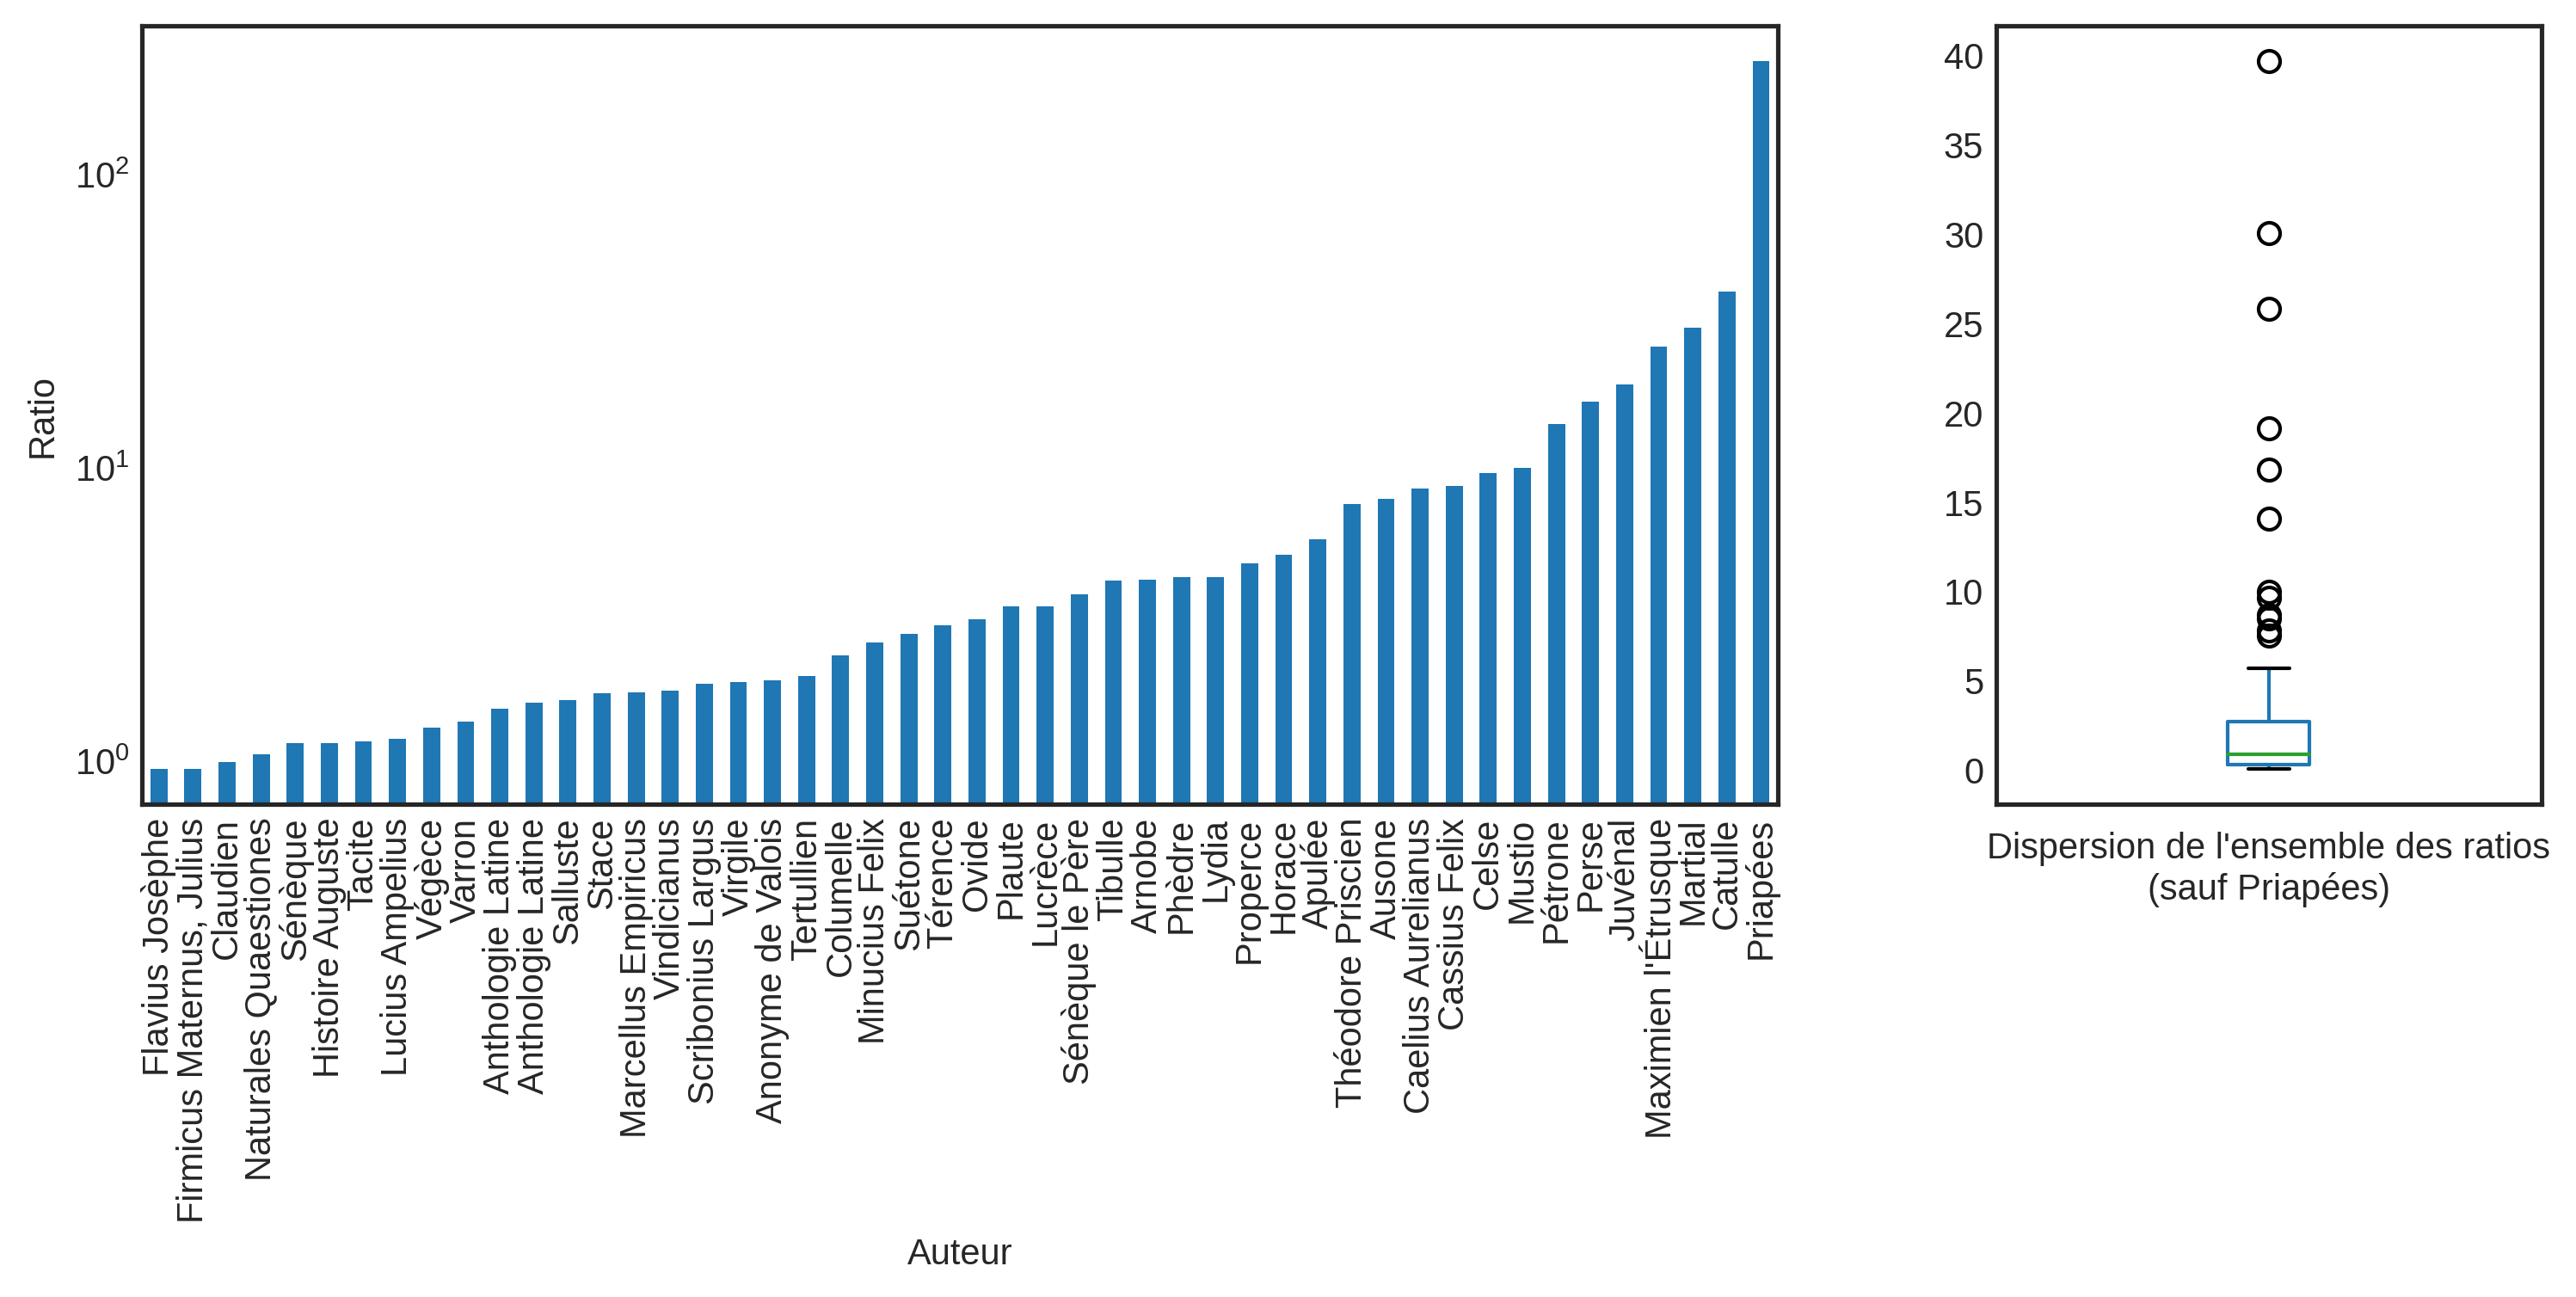

In [115]:
plt.style.use('seaborn-white')
fig, (ax1, ax2) = plt.subplots(1, 2, dpi=300, figsize=(12, 4), gridspec_kw={'width_ratios': [3, 1]})
df[df["MotsExemples%/MotsComplet%"] >= .9].sort_values("MotsExemples%/MotsComplet%").plot.bar(
    x="Auteur",
    y="MotsExemples%/MotsComplet%",
    log=True,
    ax=ax1
)
df["MotsExemples%/MotsComplet%"][df["MotsExemples%/MotsComplet%"].between(.01, 100)].plot.box(ax=ax2)
ax2.set_xticklabels([])
ax2.set_xlabel("Dispersion de l'ensemble des ratios\n(sauf Priapées)")
ax1.set_ylabel("Ratio")
ax1.legend().remove()